# Exploring FNA Image Dataset to Identify and Predict Breast Cancer
##### Daniella Raz
##### October 14, 2018

## I. Purpose
> In this notebook, I visualize and analyze the data retrieved from breast masses removed during biopsy. My goal is to build a model that can identify malignant vs benign tumors based on the breast mass features included in the dataset. As I lack training in oncology and tumor biology, my analytic approach is entirely data-driven, with a narrow aim of identifying variables that maximize classification according to the expert diagnostic decisions.


## II. About the Data
> Dataset can be found here courtesy of the University of Wisconsin: 

> https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

> This dataset contains variables that represent features extracted from digitized images of biopsy (fine needle aspirate, FNA) of a breast mass, and diagnostic decision on malignancy of the mass - malignant vs benign. "All feature values are recoded with four significant digits." The following are the features that have been extracted from each mass image:

> - radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness (perimeter^2 / area - 1.0) 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour) 
- symmetry 
- fractal dimension ("coastline approximation" - 1) 

## III. Data Exploration and Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

#### **a. Loading and Cleaning Data:**

In [3]:
#load & view data, dropping id
bc_data = pd.read_csv('data.csv')
bc_data = bc_data.drop(['id', 'Unnamed: 32'], axis = 1)
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#number of rows, columns
bc_data.shape

(569, 31)

In [5]:
#Checking datatypes, diagnosis will need to be converted to 1s and 0s
bc_data.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [6]:
#converting diagnosis to numeric
bc_data['diagnosis'] = np.where(bc_data['diagnosis']=='M', 1, 0)

In [7]:
#sanity check
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
#sanity check, are there both 1s and 0s?
bc_data['diagnosis'].unique()

array([1, 0])

In [9]:
#checking presence of any null values
bc_data.isnull().values.any()

False

In [10]:
#selecting relevant features for plotting and analysis
initial_feature_selection = [
    'diagnosis',
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'smoothness_mean',
    'compactness_mean',
    'concavity_mean',
    'concave points_mean',
    'symmetry_mean',
    'fractal_dimension_mean'
]

In [11]:
#limiting features to only those relevant
bc_data = bc_data[initial_feature_selection]
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [12]:
#getting a basic sense of the overall data
bc_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


In [13]:
bc_data.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


#### **b. Preliminary Visualizations:**

> Interpretation: 

> Intuitively, it makes sense that the size of a mass would have some correlation with diagnosis. This section examines some preliminary scatterplots comparing radius_mean (a reflection of tumor size) with other characteristics to identify some initial trends that might prove relevant once examined more rigorously.

> Figure 1.1 shows that generally malignant tumors seem to have a larger radius than do benign ones. However, tumor texture varies widely within both benign and malignant tumors. In the extremes for texture, however, we see that most masses with a very small value for texture_mean are benign. Initially, it seems that looking at radius_mean of the mass will be more useful in determining a diagnosis.

> Figure 1.2 shows that generally benign masses are concentrated in the lower left corner - meaning benign masses have a smaller mean radius and smaller value for mean compactness. In the extreme high values for both radius_mean, as shown in figure 1.1, and for compactness_mean the majority of masses are malignant. Initially, it seems that looking at at compactness_mean could provide some insight into the diagnosis of the mass. However, the combination of both a high value for compactness_mean and radius_mean seems to point to a malignant tumor. 

> Figure 1.3 shows that the combination of both a large radius and a high value for concavity_mean points to a malignant tumor. The benign masses primarily exhibit a concavity_mean value of less than 0.1. Concavity_mean might also be useful to determine the diagnosis.

In [14]:
#ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
bc_data['Diagnosis'] = bc_data['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

Text(0.5,1,'Figure 1.1')

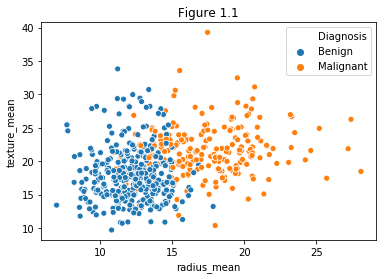

In [15]:
#exploring how radius_mean, texture_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="texture_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.1")

Text(0.5,1,'Figure 1.2')

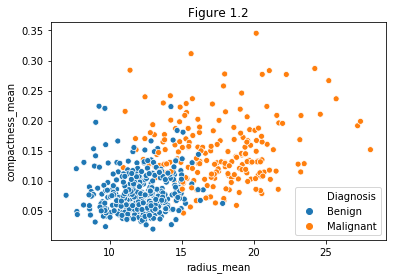

In [16]:
#exploring how radius_mean, compactness_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="compactness_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.2")

Text(0.5,1,'Figure 1.3')

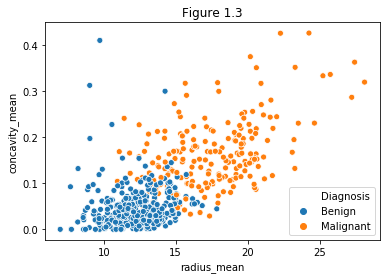

In [17]:
#exploring how radius_mean, concavity_mean correspond to diagnosis
sns.scatterplot(x="radius_mean", y="concavity_mean", hue="Diagnosis", data=bc_data, hue_order = ["Benign", "Malignant"])
ax = plt.gca()
ax.set_title("Figure 1.3")

In [37]:
#bc_data_corr = bc_data.corr()
#sns.heatmap(bc_data_corr, annot=True)
#ax = plt.gca()
#ax.set_title("Figure 2.1")

#### **d. Multicollinearity:**

> Interpretation:

> > > **did i do this correctly? or do you first put it in a model and then check vif**

In [19]:
#removing diagnosis from features list
features = list(initial_feature_selection)
features.remove("diagnosis")

In [20]:
#sanity check
print(features)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']


In [21]:
vif_data = bc_data[features].copy()
vif_data.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [22]:
from statsmodels.tools.tools import add_constant

x = add_constant(vif_data)
pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)

const                     1306.240796
radius_mean               1606.805835
texture_mean                 1.186978
perimeter_mean            1956.135364
area_mean                   56.283984
smoothness_mean              2.957080
compactness_mean            22.619498
concavity_mean              11.715217
concave points_mean         21.711976
symmetry_mean                1.778451
fractal_dimension_mean       6.472842
dtype: float64

#### **e. Examining Benign versus Malignant Masses:**

> Interpretation: 

> At first glance, here are some notable differences between malignant and benign masses. 
> - The mean for every variable measuring mass size (area, radius, perimeter) is larger for malignant masses than for benign ones.
>>> - ***Comparing standard deviations, ***
>>> - ***Compare 25% and 50% and 75% ***


In [23]:
#describes data for malignant breast masses 
malignant_data = bc_data.loc[bc_data['diagnosis'] == 1]
malignant_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1.0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680
std,0.0,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,0.007573
min,1.0,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,0.130800,0.049960
25%,1.0,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,0.174050,0.056598
50%,1.0,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,0.189900,0.061575
75%,1.0,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,0.209850,0.067075
max,1.0,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440


In [24]:
#describes data for benign breast masses
benign_data = bc_data.loc[bc_data['diagnosis'] == 0]
benign_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,357.0,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.0,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867
std,0.0,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,0.006747
min,0.0,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.051850
25%,0.0,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,0.158000,0.058530
50%,0.0,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,0.171400,0.061540
75%,0.0,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,0.189000,0.065760
max,0.0,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,0.274300,0.095750


#### **f. Distributions:**

> Interpretation:

> Most features seem normally distributed for both benign and malignant masses. 
>>>>*** However, ***

In [25]:
def multiplePlots(feature_name, n):
    #plot set up, sizing, title, padding
    fig, axs = plt.subplots(1, 2, sharey = False)
    plt.tight_layout(w_pad=6)
    fig.subplots_adjust(top=0.85)
    fig.suptitle('Figure 2.'+str(n)+': Distribution of ' + feature_name + ' variable', fontsize=15)
    
    #histogram for benign
    axs[0].set_title('Histogram for Benign vs. Malignant')
    sns.distplot(benign_data[feature], ax=axs[0], label="benign")
    #histogram for malignant
    sns.distplot(malignant_data[feature], ax=axs[0], label="malignant")
    axs[0].legend()
    
    #QQ plot for benign
    axs[1].set_title('QQ Plot for Benign vs. Malignant')
    qntls, xr = stats.probplot(benign_data[feature], fit=False)
    sns.regplot(xr,qntls, ax=axs[1], label="benign")
    #QQ plot for malignant
    qntls2, xr2 = stats.probplot(malignant_data[feature], fit=False)
    sns.regplot(xr2,qntls2, ax=axs[1], label="malignant")
    axs[1].legend()

/Users/daniellaraz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


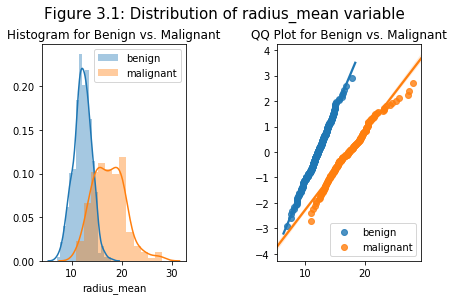

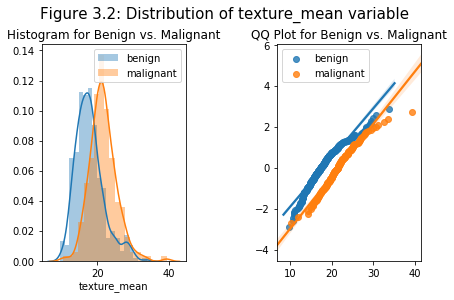

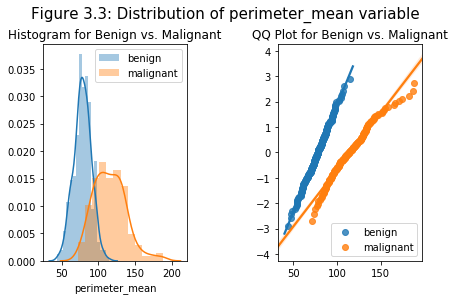

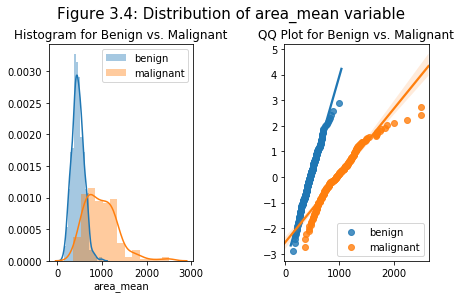

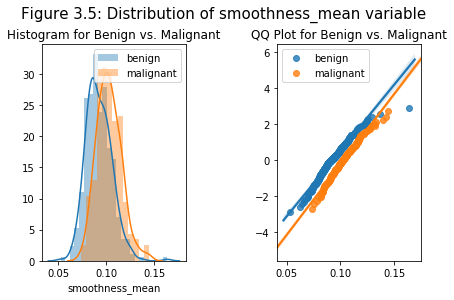

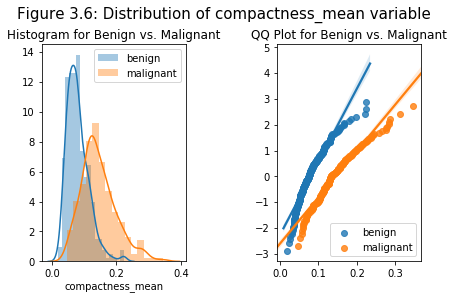

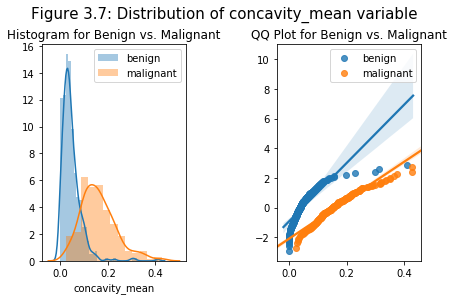

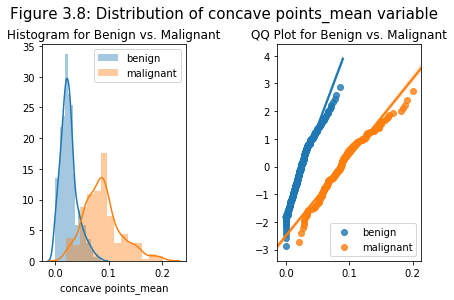

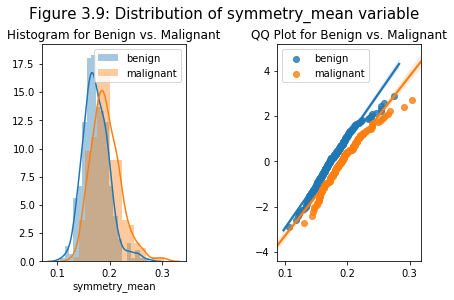

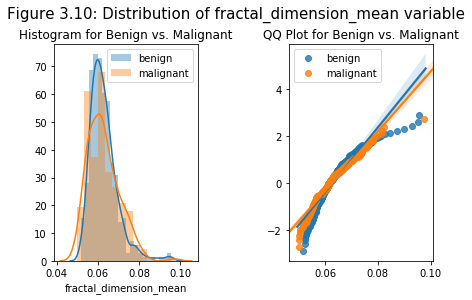

In [26]:
#plotting distributions plots (histogram and qqplot) of all variables for both benign and malignant
n = 1
for feature in features:
    multiplePlots(feature, n)
    n += 1

#### **g. Outliers, Addt'l Distribution Plots, and Dispersion:**

> Interpretation:

> 

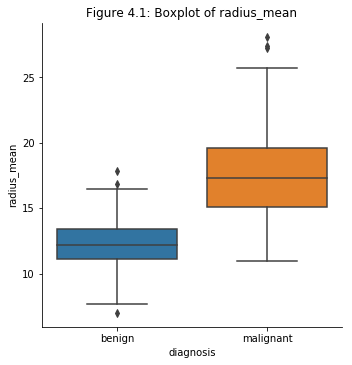

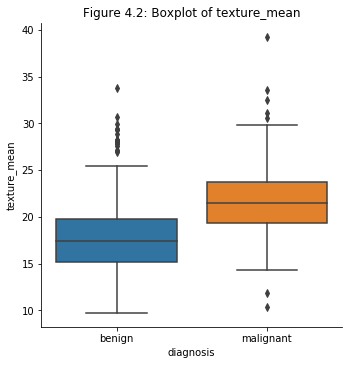

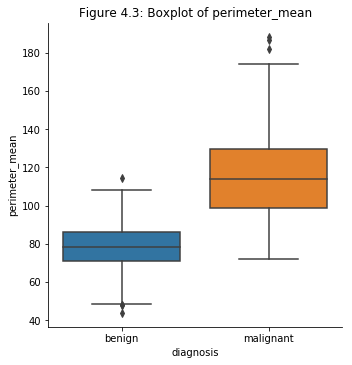

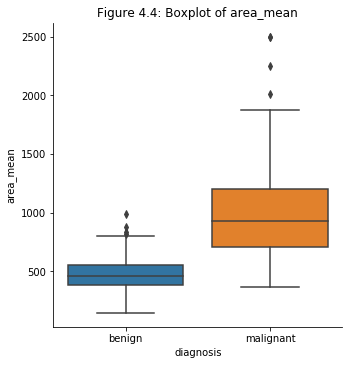

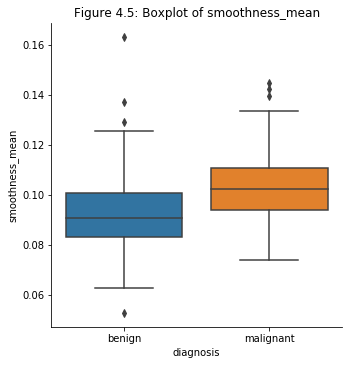

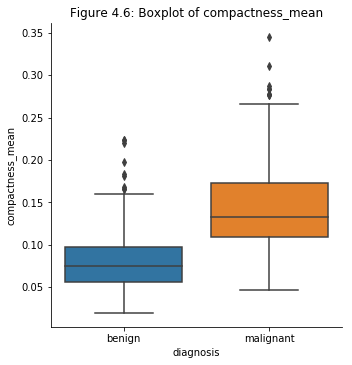

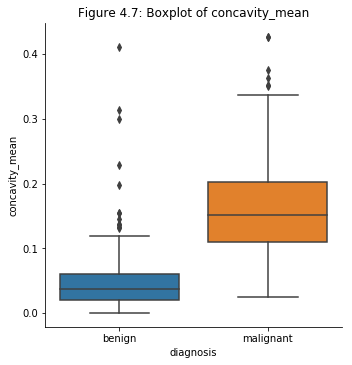

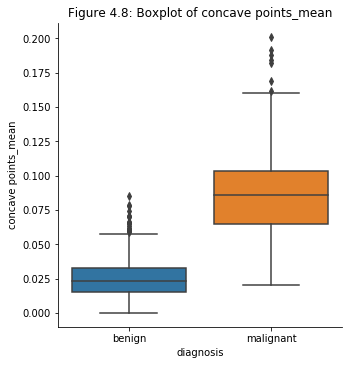

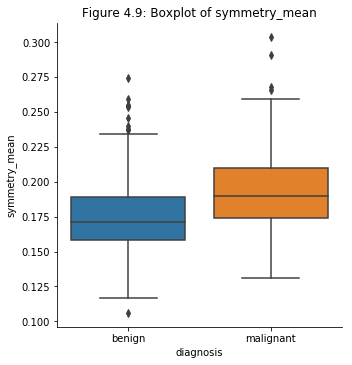

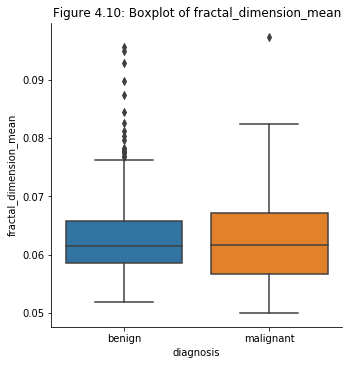

In [27]:
figure_count = 1
for feature in features:
    g = sns.catplot(x="diagnosis", y=feature, data=bc_data, kind="box", height=5, aspect=1, legend = True).set_xticklabels(["benign", "malignant"])
    ax = plt.gca()
    ax.set_title("Figure 3."+str(figure_count) + ": Boxplot of " + feature)
    figure_count += 1

#### **h. Dispersion:**

> Interpretation

In [28]:
print(np.percentile(bc_data['radius_mean'], 2.5), "-", np.percentile(bc_data['radius_mean'], 97.5))

8.9004 - 21.741999999999997


Here are a few observations based on the distribution plots:
- radius, texture, perimeter, area, concavity (average & average points) appear to be mostly distinct based on the diagnosis 
- smoothness, compactness, symmetry, fractal appear to have significant overlap regardless of diagnosis 

As a next step for identifying which features would give us the best model to determine whether a mass is malignant or benign, I conduct principal component analysis (PCA).

The first step of this process is standardizing the data.

#### **i. Standardizing Data, Looking at Correlations and Clusters:**

> Interpretation:

> Figure 2.1 shows that, unsurprisingly, variables measuring size of the mass like radius_mean, perimeter_mean, and area_mean are highly correlated with each other. This suggests that in our later models measuring the predictive power of only one of these variables will suffice. 

> Other variables exhibiting strong correlations are concave points_mean with both radius_mean, perimeter_mean, area_mean, and obviously with concavity_mean . 

> > > **WHAT DOES THIS SAY ABOUT VARIABLES I SHOULD GET RID OF???**

In [29]:
from sklearn.preprocessing import StandardScaler

# extract features & targets from original dataframe 
feature_data = bc_data[features]
target_data = bc_data[['diagnosis']]

# sanity check
feature_data.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [30]:
# sanity check
target_data.head(5)

,diagnosis
0,1
1,1
2,1
3,1
4,1


In [31]:
# sanity check, are there both 1s and 0s?
target_data['diagnosis'].unique()

array([1, 0])

In [32]:
# standardize the features
processed_feature_data = pd.DataFrame(StandardScaler().fit_transform(feature_data), columns=features)
# sanity check
processed_feature_data.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450


In [33]:
processed_feature_data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-1.256562e-16,1.049736e-16,-1.272171e-16,-1.900452e-16,1.490704e-16,2.544342e-16,-1.338511e-16,-8.429110e-17,2.081912e-16,5.408679e-16
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00


Text(0.5,0.98,'Figure 4.1')

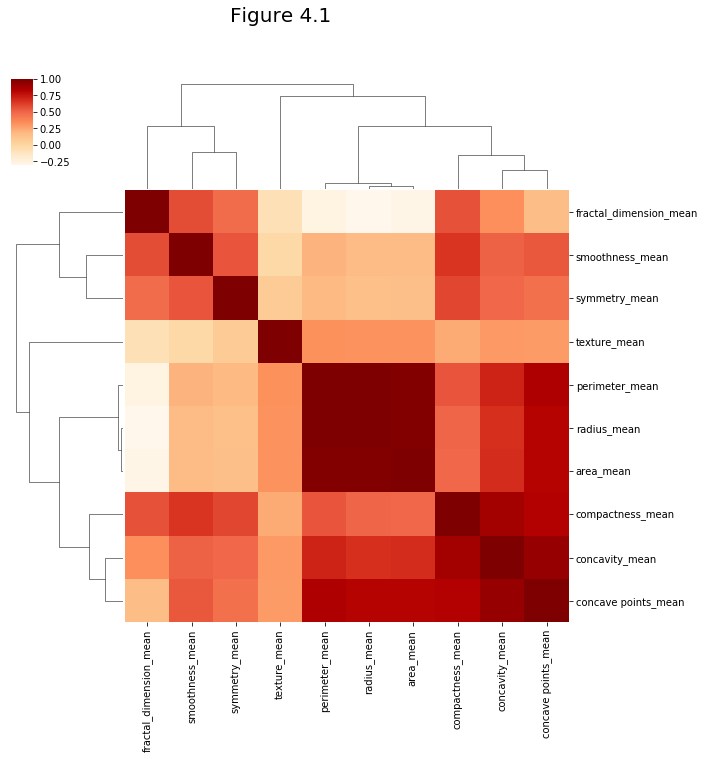

In [55]:
g = sns.clustermap(processed_feature_data.corr(),cmap=plt.cm.OrRd)
g.fig.suptitle('Figure 4.1', fontsize = 20) 

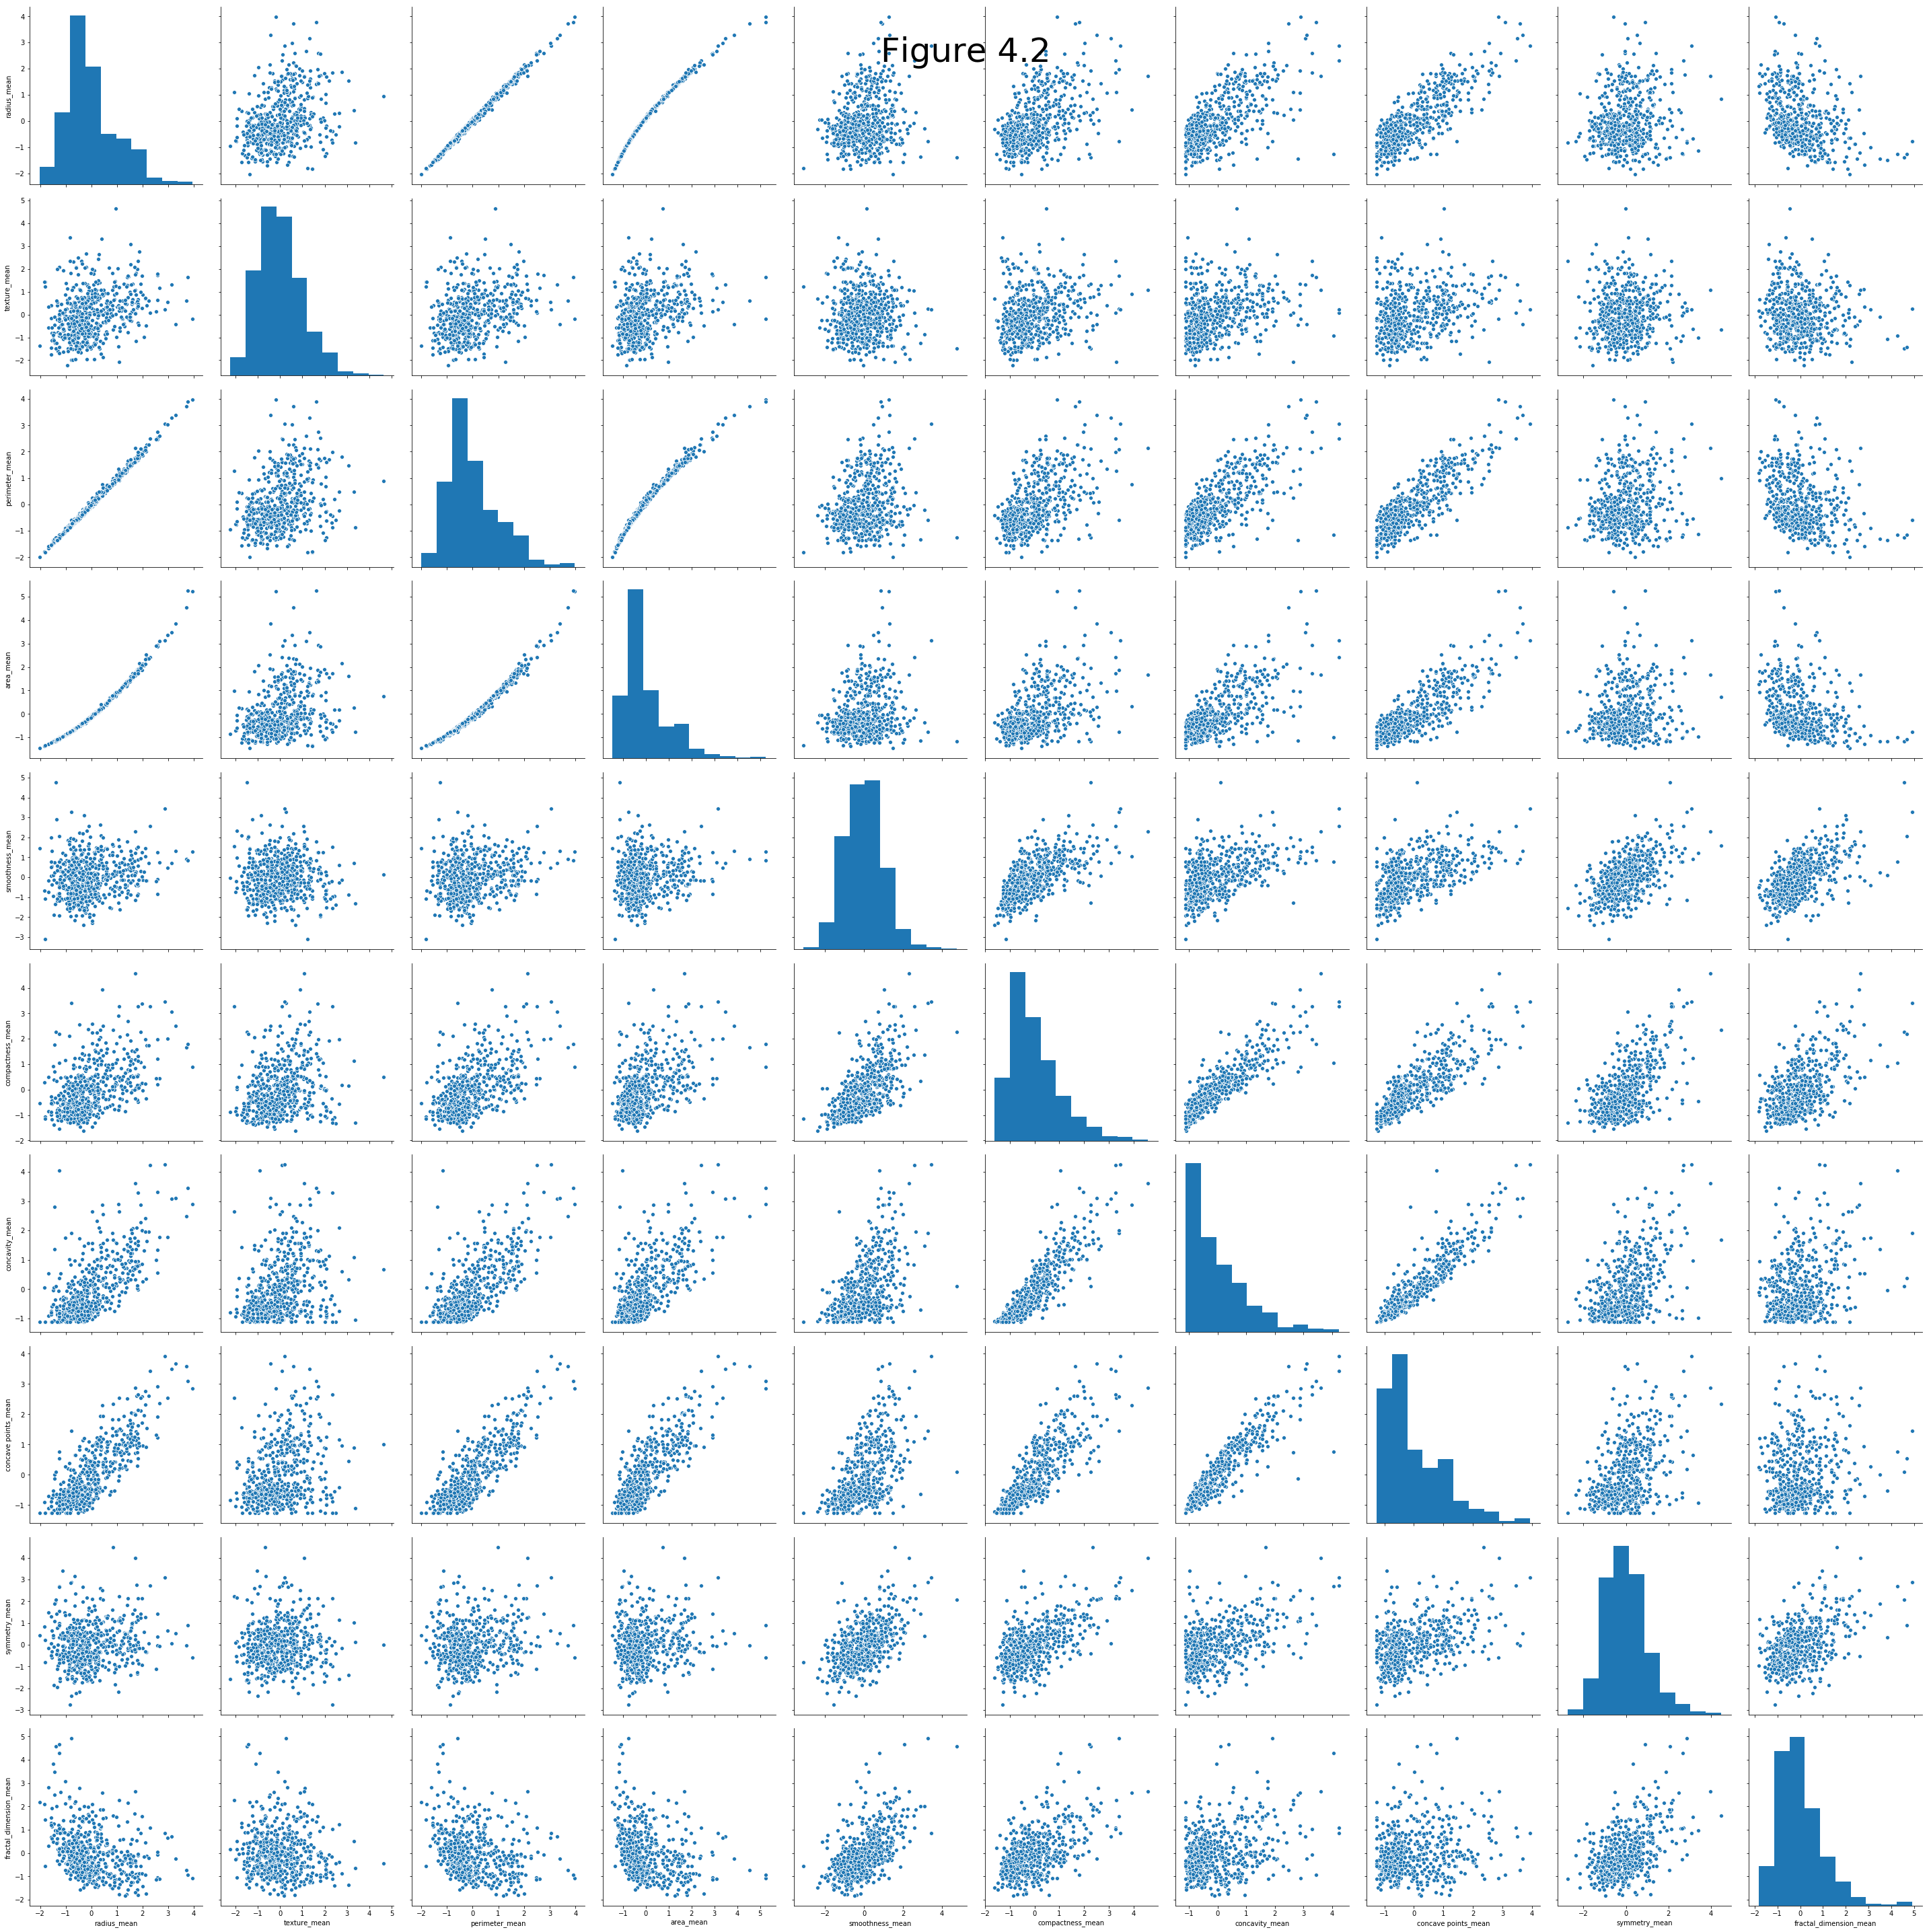

In [62]:
sns.pairplot(processed_feature_data)

#### **j. Dimension Reduction:**

> Interpretation:

> Looking at scree plot to find the point at which the marginal advantage of an additional component (meaning the additional amount of variance it explains) drops off. Judging by the scree plot it seems to be around 2 or 3 components.

> 

Reducing the data from 10 dimensions to 'n' dimensions.

In [68]:
from sklearn.decomposition import PCA
import sklearn.decomposition as skd

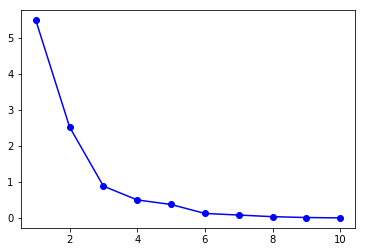

In [69]:
pca_model = skd.PCA().fit(processed_feature_data)
plt.plot(range(1,11),pca_model.explained_variance_,'b-o')

In [77]:
# Create a three-factor model
fa_model = skd.FactorAnalysis(n_components=3) \
              .fit(processed_feature_data)

# Show the loadings
df_loadings = pd.DataFrame(fa_model.components_[:3,:].T, 
                   index=processed_feature_data.columns,
                   columns=['Factor1', 'Factor2', 'Factor3'])
df_loadings

,Factor1,Factor2,Factor3
radius_mean,0.998254,-0.052369,-0.017066
texture_mean,0.328969,0.023696,0.211300
perimeter_mean,0.999948,0.005875,0.002347
area_mean,0.986812,-0.042150,-0.019820
smoothness_mean,0.203820,0.795710,-0.519111
compactness_mean,0.551830,0.795775,0.168383
concavity_mean,0.712298,0.593086,0.171570
concave points_mean,0.848325,0.468859,-0.012287
symmetry_mean,0.179567,0.633794,-0.037076
fractal_dimension_mean,-0.266557,0.861714,0.088147


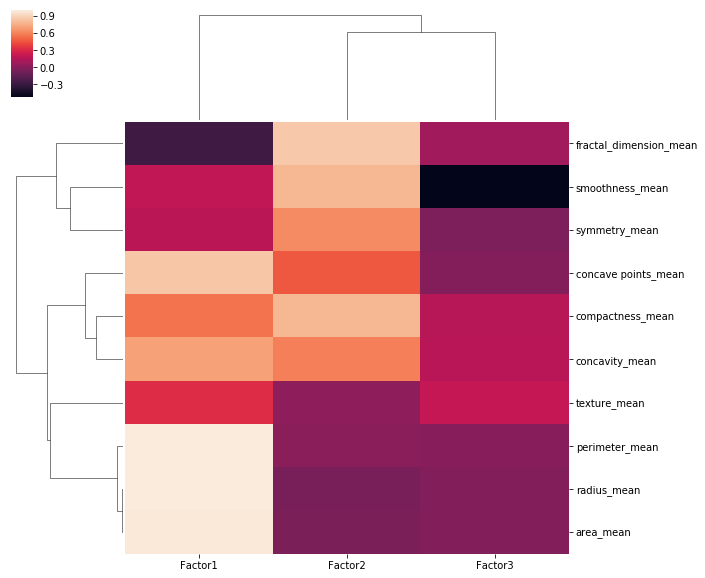

In [78]:
sns.clustermap(df_loadings)

In [70]:
# Checking 3 components given scree plot results
pca = PCA(n_components=3)
principal_components = pca.fit_transform(processed_feature_data)
principal_df = pd.DataFrame(data = principal_components, columns=['p1', 'p2', 'p3'])

# sanity check
principal_df.head(5)

,p1,p2,p3
0,5.224155,3.204428,-2.171340
1,1.728094,-2.540839,-1.019679
2,3.969757,-0.550075,-0.323569
3,3.596713,6.905070,0.792832
4,3.151092,-1.358072,-1.862234


In [71]:
# not a significant amount of variance explained by the third component
pca.explained_variance_ratio_

array([0.5478588 , 0.25187136, 0.08806152])

In [72]:
# Checking 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(processed_feature_data)
principal_df = pd.DataFrame(data = principal_components, columns=['p1', 'p2'])

# sanity check
principal_df.head(5)

,p1,p2
0,5.224155,3.204428
1,1.728094,-2.540839
2,3.969757,-0.550075
3,3.596713,6.905070
4,3.151092,-1.358072


In [73]:
final_df = pd.concat([principal_df, bc_data[['diagnosis']]], axis = 1)
#sanity check
final_df.head(5)

,p1,p2,diagnosis
0,5.224155,3.204428,1
1,1.728094,-2.540839,1
2,3.969757,-0.550075,1
3,3.596713,6.905070,1
4,3.151092,-1.358072,1


In [74]:
pca.explained_variance_ratio_

array([0.5478588 , 0.25187136])

In [75]:
feature_loading = pd.DataFrame(pca.components_,columns=processed_feature_data.columns,index = ['p1','p2'])

In [76]:
feature_loading

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
p1,0.363938,0.154451,0.376044,0.364086,0.232481,0.364442,0.395748,0.418038,0.215238,0.071837
p2,-0.313929,-0.147181,-0.284658,-0.304842,0.401962,0.266013,0.104286,0.007184,0.368301,0.571768


In [126]:
#ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
final_df['Diagnosis'] = final_df['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

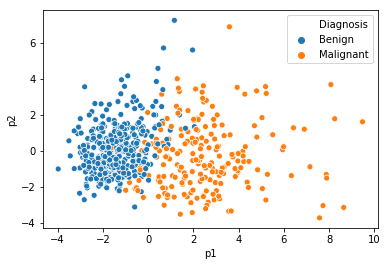

In [127]:
sns.scatterplot(x='p1', y='p2', hue="Diagnosis", data=final_df, hue_order = ["Benign", "Malignant"])

Overall, we can say that approximately 80% of the information in this dataset can be explained by 'p1' and 'p2'. Now, 80% is ok, but let's see if there is a better explanation of the data with fewer features. Looking at the distribution plots above, I remove the features that had significant overlap with each other in the malignant and benign samples and apply PCA again. Here are the features I remove:
- smoothness
- compactness
- symmetry
- fractal 

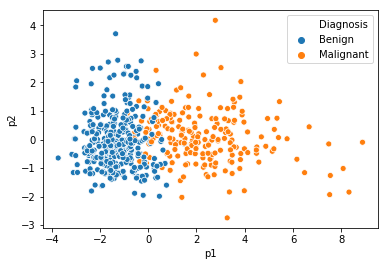

In [81]:
from sklearn.preprocessing import StandardScaler

# extract features & targets from original dataframe 
features = [
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'concavity_mean',
    'concave points_mean'
]

feature_data = bc_data[features]
target_data = bc_data['diagnosis']

# standardize the features
processed_feature_data = pd.DataFrame(StandardScaler().fit_transform(feature_data), columns=features)

# reduce the dimensionality of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(processed_feature_data)
principal_df = pd.DataFrame(data = principal_components, columns=['p1', 'p2'])

# rebuild the dataframe with principal components and diagnosis 
final_df = pd.concat([principal_df, bc_data[['diagnosis']]], axis = 1)

#ensuring that legend displays benign and malignant, not 1 and 0, and consistency of colors
final_df['Diagnosis'] = final_df['diagnosis'].map({0: 'Benign', 1: 'Malignant'})

# put data on scatterplot
sns.scatterplot(x='p1', y='p2', hue="Diagnosis", data=final_df, hue_order = ["Benign", "Malignant"])

In [82]:
print(pca.explained_variance_ratio_)

[0.75614398 0.14358948]


In [83]:
feature_loadings = pd.DataFrame(pca.components_,columns=processed_feature_data.columns,index = ['p1','p2'])

In [84]:
feature_loadings

,radius_mean,texture_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean
p1,0.449871,0.194783,0.456228,0.449491,0.396519,0.438477
p2,-0.089836,0.980192,-0.089144,-0.092402,-0.050563,-0.110054


In [62]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings

array([[ 0.85259661, -0.49865812],
       [ 0.36183233, -0.23378834],
       [ 0.88095829, -0.45216254],
       [ 0.85294315, -0.48422338],
       [ 0.54463165,  0.63849383],
       [ 0.85377764,  0.42254645],
       [ 0.92711915,  0.16565221],
       [ 0.97933768,  0.01141074],
       [ 0.50423754,  0.58502463],
       [ 0.16829341,  0.90821982]])

By removing the features that had similar characteristics regardless of diagnosis (smoothness, compactness, symmetry, and fractal), and then creating components based on the remaining feature, it is now possible to explain 90% of the information through 'p1' and 'p2', which means that these features primarily determine whether a sample is malignant or benign:

- radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour)

Therefore, if in building a logistic model to predict whether a given sample is malignant or benign, these would be the criteria the model should evaluate.

## IV. Predictive Modeling

#### **a. Logistic Regression:**

> Interpretation: